In [2]:
import sqlite3
import pandas as pd

# file path
conn = sqlite3.connect("Chinook_Sqlite.sqlite")

# check tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)


             name
0           Album
1          Artist
2        Customer
3        Employee
4           Genre
5         Invoice
6     InvoiceLine
7       MediaType
8        Playlist
9   PlaylistTrack
10          Track


# SQL Queries

# (A) Top-Selling Products

We need to join InvoiceLine with Track and calculate revenue.

In [5]:
import pandas as pd

query = """
SELECT
    t.Name AS TrackName,
    SUM(il.UnitPrice * il.Quantity) AS TotalRevenue
FROM InvoiceLine il
JOIN Track t ON il.TrackId = t.TrackId
GROUP BY t.Name
ORDER BY TotalRevenue DESC
LIMIT 10;
"""

# run query
top_products = pd.read_sql(query, conn)
print(top_products)


                      TrackName  TotalRevenue
0                   The Trooper          4.95
1                     Walkabout          3.98
2                The Woman King          3.98
3                       The Fix          3.98
4                         Pilot          3.98
5             Phyllis's Wedding          3.98
6  How to Stop an Exploding Man          3.98
7                      Hot Girl          3.98
8                Gay Witch Hunt          3.98
9                Branch Closing          3.98


/tmp/ipython-input-2933601258.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x="TotalRevenue", y="TrackName", palette="viridis")


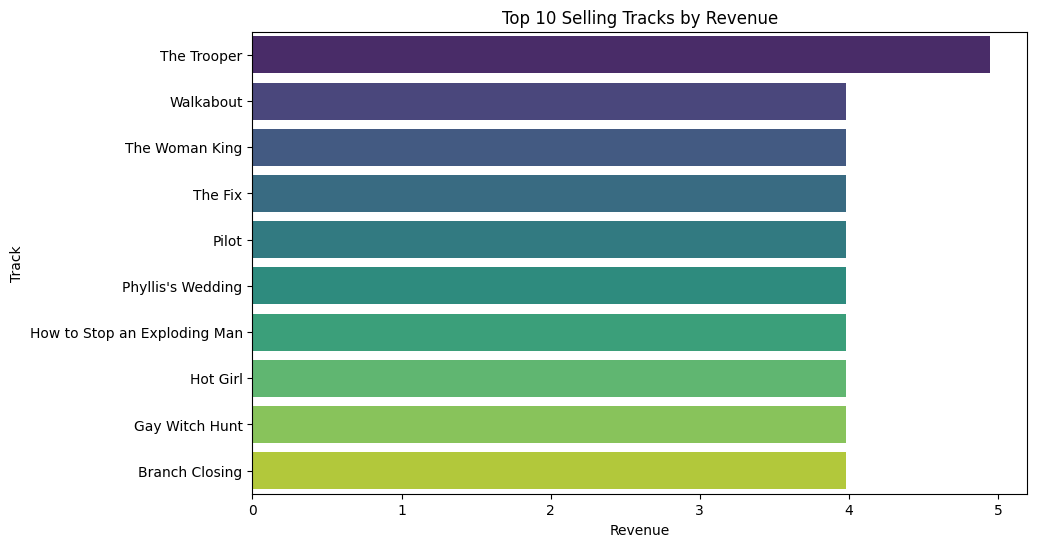

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 products
query_top = """
SELECT
    t.Name AS TrackName,
    SUM(il.UnitPrice * il.Quantity) AS TotalRevenue
FROM InvoiceLine il
JOIN Track t ON il.TrackId = t.TrackId
GROUP BY t.Name
ORDER BY TotalRevenue DESC
LIMIT 10;
"""
top_products = pd.read_sql(query_top, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=top_products, x="TotalRevenue", y="TrackName", palette="viridis")
plt.title("Top 10 Selling Tracks by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Track")
plt.show()


# (B) Revenue Per Region (Country)

We join Invoice with Customer.

In [6]:
query_region = """
SELECT
    c.Country,
    SUM(i.Total) AS Revenue
FROM Invoice i
JOIN Customer c ON i.CustomerId = c.CustomerId
GROUP BY c.Country
ORDER BY Revenue DESC;
"""

revenue_region = pd.read_sql(query_region, conn)
print(revenue_region)


           Country  Revenue
0              USA   523.06
1           Canada   303.96
2           France   195.10
3           Brazil   190.10
4          Germany   156.48
5   United Kingdom   112.86
6   Czech Republic    90.24
7         Portugal    77.24
8            India    75.26
9            Chile    46.62
10         Ireland    45.62
11         Hungary    45.62
12         Austria    42.62
13         Finland    41.62
14     Netherlands    40.62
15          Norway    39.62
16          Sweden    38.62
17          Poland    37.62
18           Italy    37.62
19         Denmark    37.62
20       Australia    37.62
21       Argentina    37.62
22           Spain    37.62
23         Belgium    37.62


/tmp/ipython-input-1675335489.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_region, x="Revenue", y="Country", palette="magma")


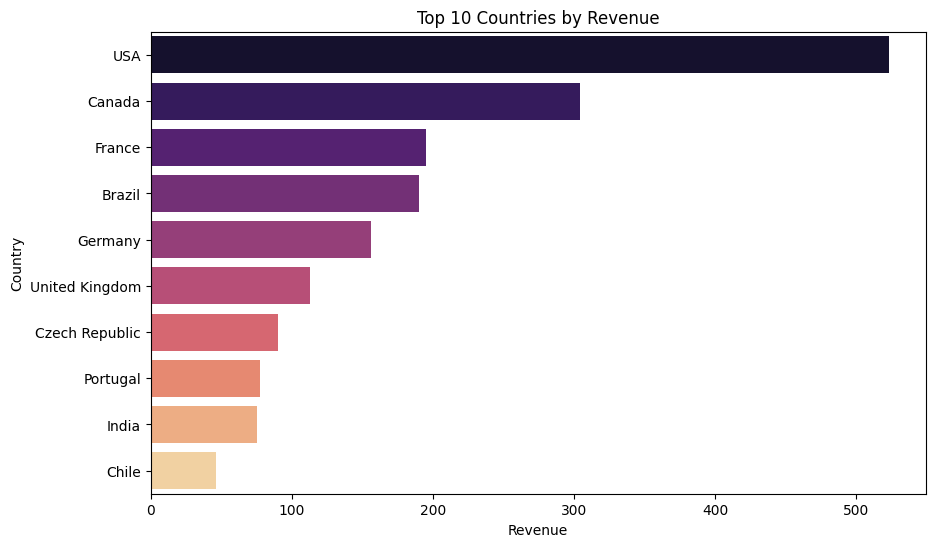

In [11]:
query_region = """
SELECT
    c.Country,
    SUM(i.Total) AS Revenue
FROM Invoice i
JOIN Customer c ON i.CustomerId = c.CustomerId
GROUP BY c.Country
ORDER BY Revenue DESC
LIMIT 10;
"""
revenue_region = pd.read_sql(query_region, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=revenue_region, x="Revenue", y="Country", palette="magma")
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.show()


# (C) Monthly Performance

We extract month and year from InvoiceDate.

In [7]:
query_monthly = """
SELECT
    strftime('%Y-%m', i.InvoiceDate) AS YearMonth,
    SUM(i.Total) AS MonthlyRevenue
FROM Invoice i
GROUP BY YearMonth
ORDER BY YearMonth;
"""

monthly_performance = pd.read_sql(query_monthly, conn)
print(monthly_performance)


   YearMonth  MonthlyRevenue
0    2009-01           35.64
1    2009-02           37.62
2    2009-03           37.62
3    2009-04           37.62
4    2009-05           37.62
5    2009-06           37.62
6    2009-07           37.62
7    2009-08           37.62
8    2009-09           37.62
9    2009-10           37.62
10   2009-11           37.62
11   2009-12           37.62
12   2010-01           52.62
13   2010-02           46.62
14   2010-03           44.62
15   2010-04           37.62
16   2010-05           37.62
17   2010-06           37.62
18   2010-07           37.62
19   2010-08           37.62
20   2010-09           36.63
21   2010-10           37.62
22   2010-11           37.62
23   2010-12           37.62
24   2011-01           37.62
25   2011-02           37.62
26   2011-03           37.62
27   2011-04           51.62
28   2011-05           42.62
29   2011-06           50.62
30   2011-07           37.62
31   2011-08           37.62
32   2011-09           37.62
33   2011-10  

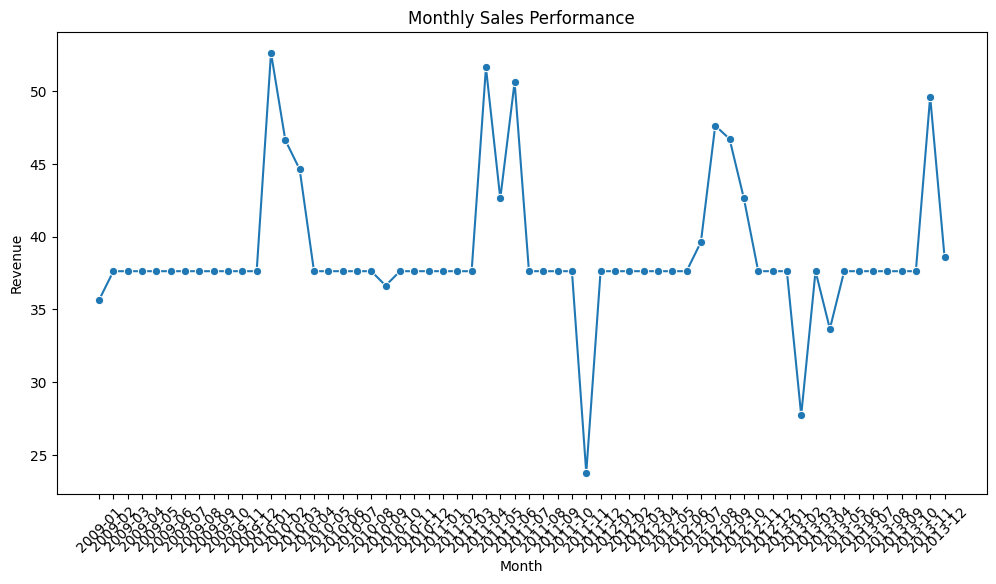

In [12]:
query_monthly = """
SELECT
    strftime('%Y-%m', i.InvoiceDate) AS YearMonth,
    SUM(i.Total) AS MonthlyRevenue
FROM Invoice i
GROUP BY YearMonth
ORDER BY YearMonth;
"""
monthly_performance = pd.read_sql(query_monthly, conn)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_performance, x="YearMonth", y="MonthlyRevenue", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Sales Performance")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()


# Bonus (Window Function)

Find Top 3 tracks per artist by revenue using RANK().

In [9]:
query_window = """
SELECT *
FROM (
    SELECT
        a.Name AS Artist,
        t.Name AS Track,
        SUM(il.UnitPrice * il.Quantity) AS Revenue,
        RANK() OVER(
            PARTITION BY a.Name
            ORDER BY SUM(il.UnitPrice * il.Quantity) DESC
        ) AS RankInArtist
    FROM InvoiceLine il
    JOIN Track t ON il.TrackId = t.TrackId
    JOIN Album al ON t.AlbumId = al.AlbumId
    JOIN Artist a ON al.ArtistId = a.ArtistId
    GROUP BY a.Name, t.Name
) sub
WHERE RankInArtist <= 3;
"""

top_tracks_per_artist = pd.read_sql(query_window, conn)
print(top_tracks_per_artist.head(20))



                                               Artist  \
0                                               AC/DC   
1                                               AC/DC   
2                                               AC/DC   
3   Academy of St. Martin in the Fields & Sir Nevi...   
4   Academy of St. Martin in the Fields, John Birc...   
5   Academy of St. Martin in the Fields, Sir Nevil...   
6                                              Accept   
7                                              Accept   
8                                              Accept   
9                                              Accept   
10                     Adrian Leaper & Doreen de Feis   
11                                          Aerosmith   
12                                          Aerosmith   
13                                          Aerosmith   
14                                          Aerosmith   
15                                          Aerosmith   
16                             

# Visualization for One Artist (Example: AC/DC)

/tmp/ipython-input-3441129648.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=artist_data, x="Revenue", y="Track", palette="coolwarm")


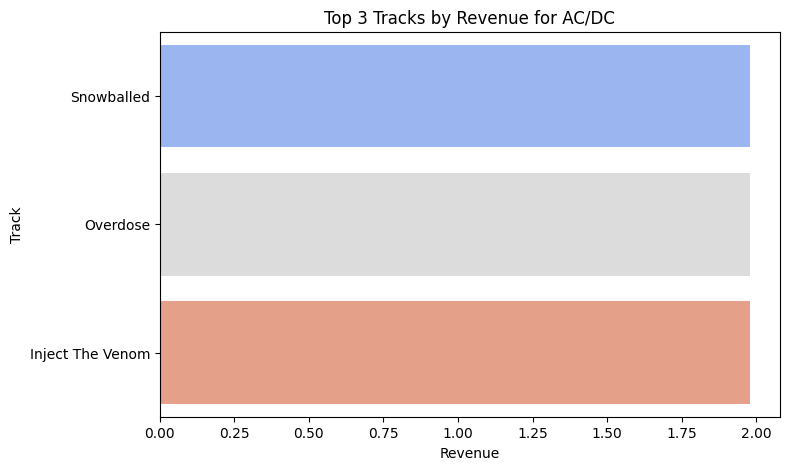

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

artist_name = "AC/DC"
artist_data = top_tracks_per_artist[top_tracks_per_artist["Artist"] == artist_name]

plt.figure(figsize=(8,5))
sns.barplot(data=artist_data, x="Revenue", y="Track", palette="coolwarm")
plt.title(f"Top 3 Tracks by Revenue for {artist_name}")
plt.xlabel("Revenue")
plt.ylabel("Track")
plt.show()


# Visualization for Multiple Artists

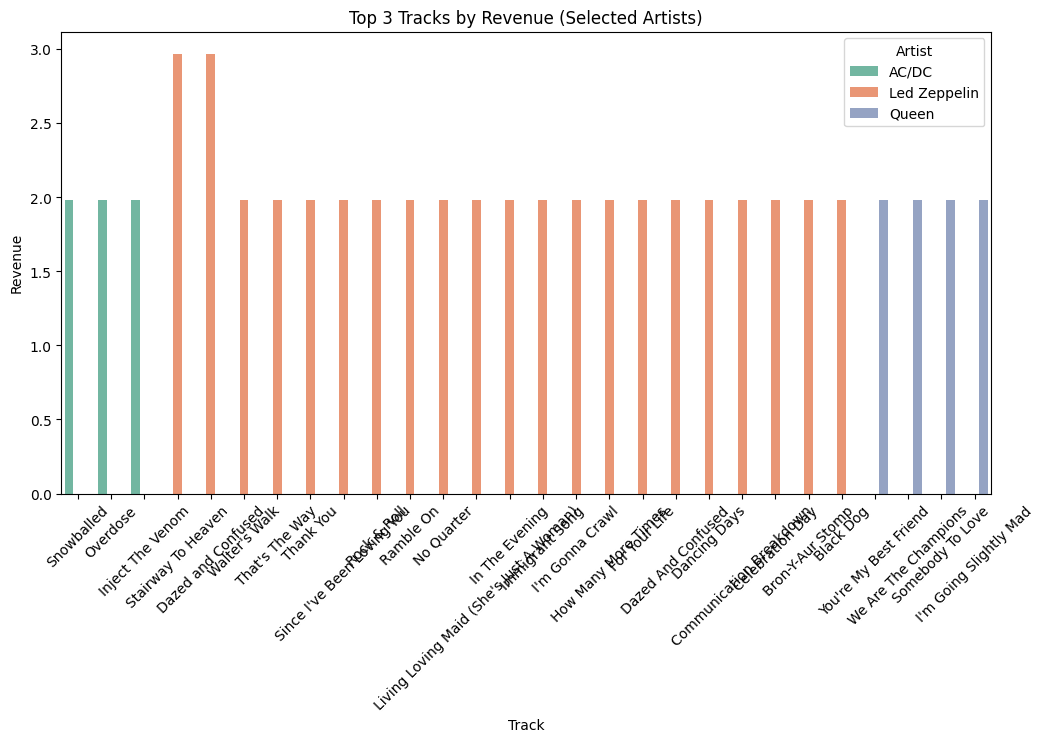

In [14]:
# Only for 3 artists
artists_to_plot = ["AC/DC", "Queen", "Led Zeppelin"]
subset = top_tracks_per_artist[top_tracks_per_artist["Artist"].isin(artists_to_plot)]

plt.figure(figsize=(12,6))
sns.barplot(data=subset, x="Track", y="Revenue", hue="Artist", dodge=True, palette="Set2")
plt.title("Top 3 Tracks by Revenue (Selected Artists)")
plt.xticks(rotation=45)
plt.show()
